Running Comprehensive Waveguide SHG Analysis...

1. Visualizing Waveguide Structures...


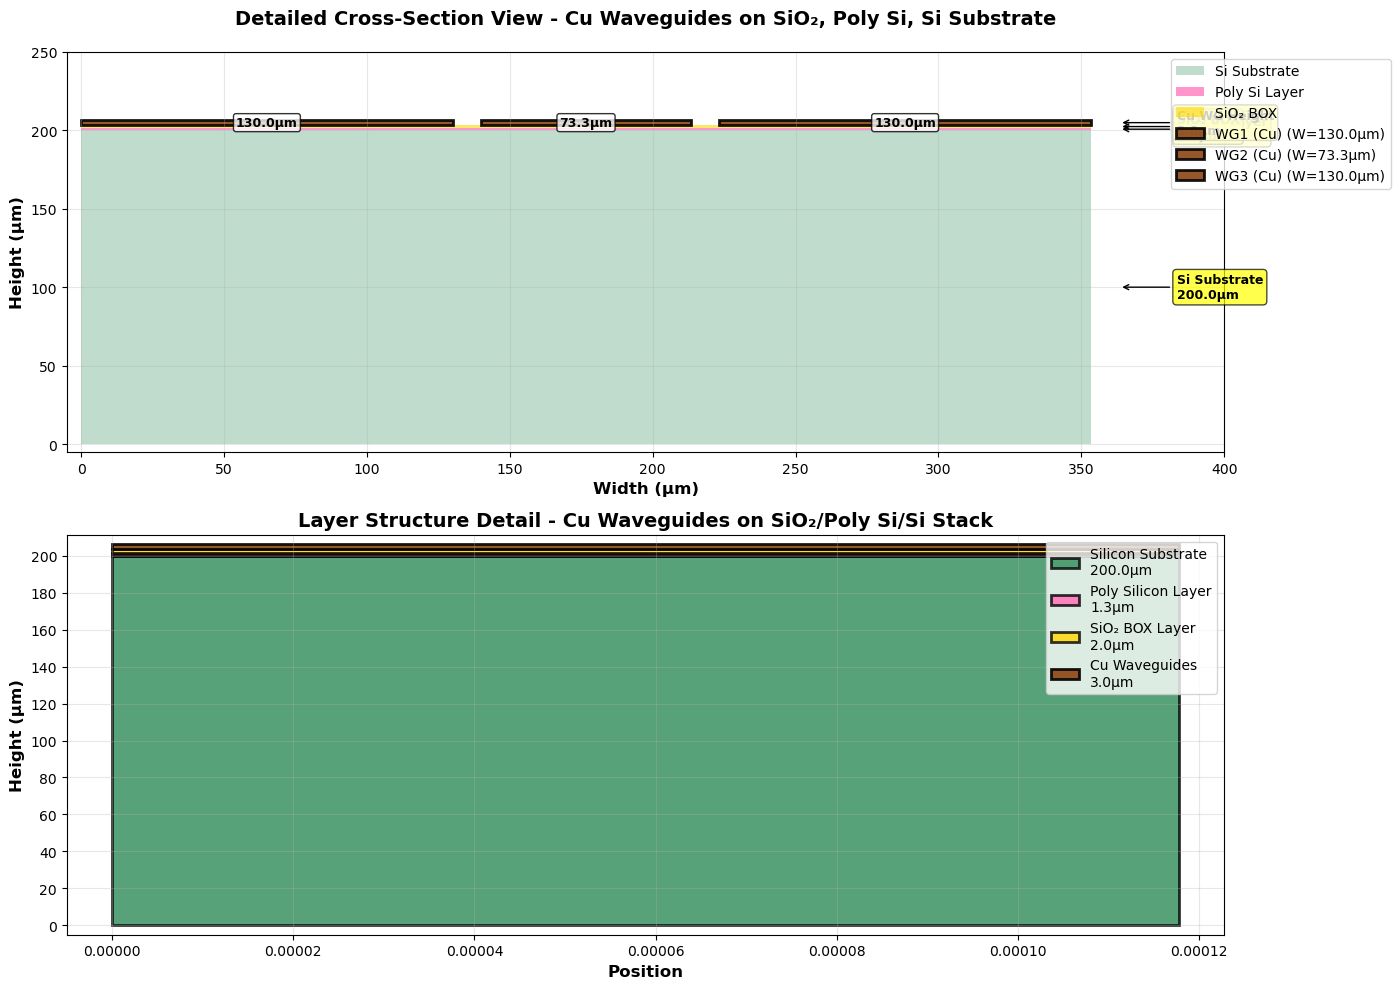

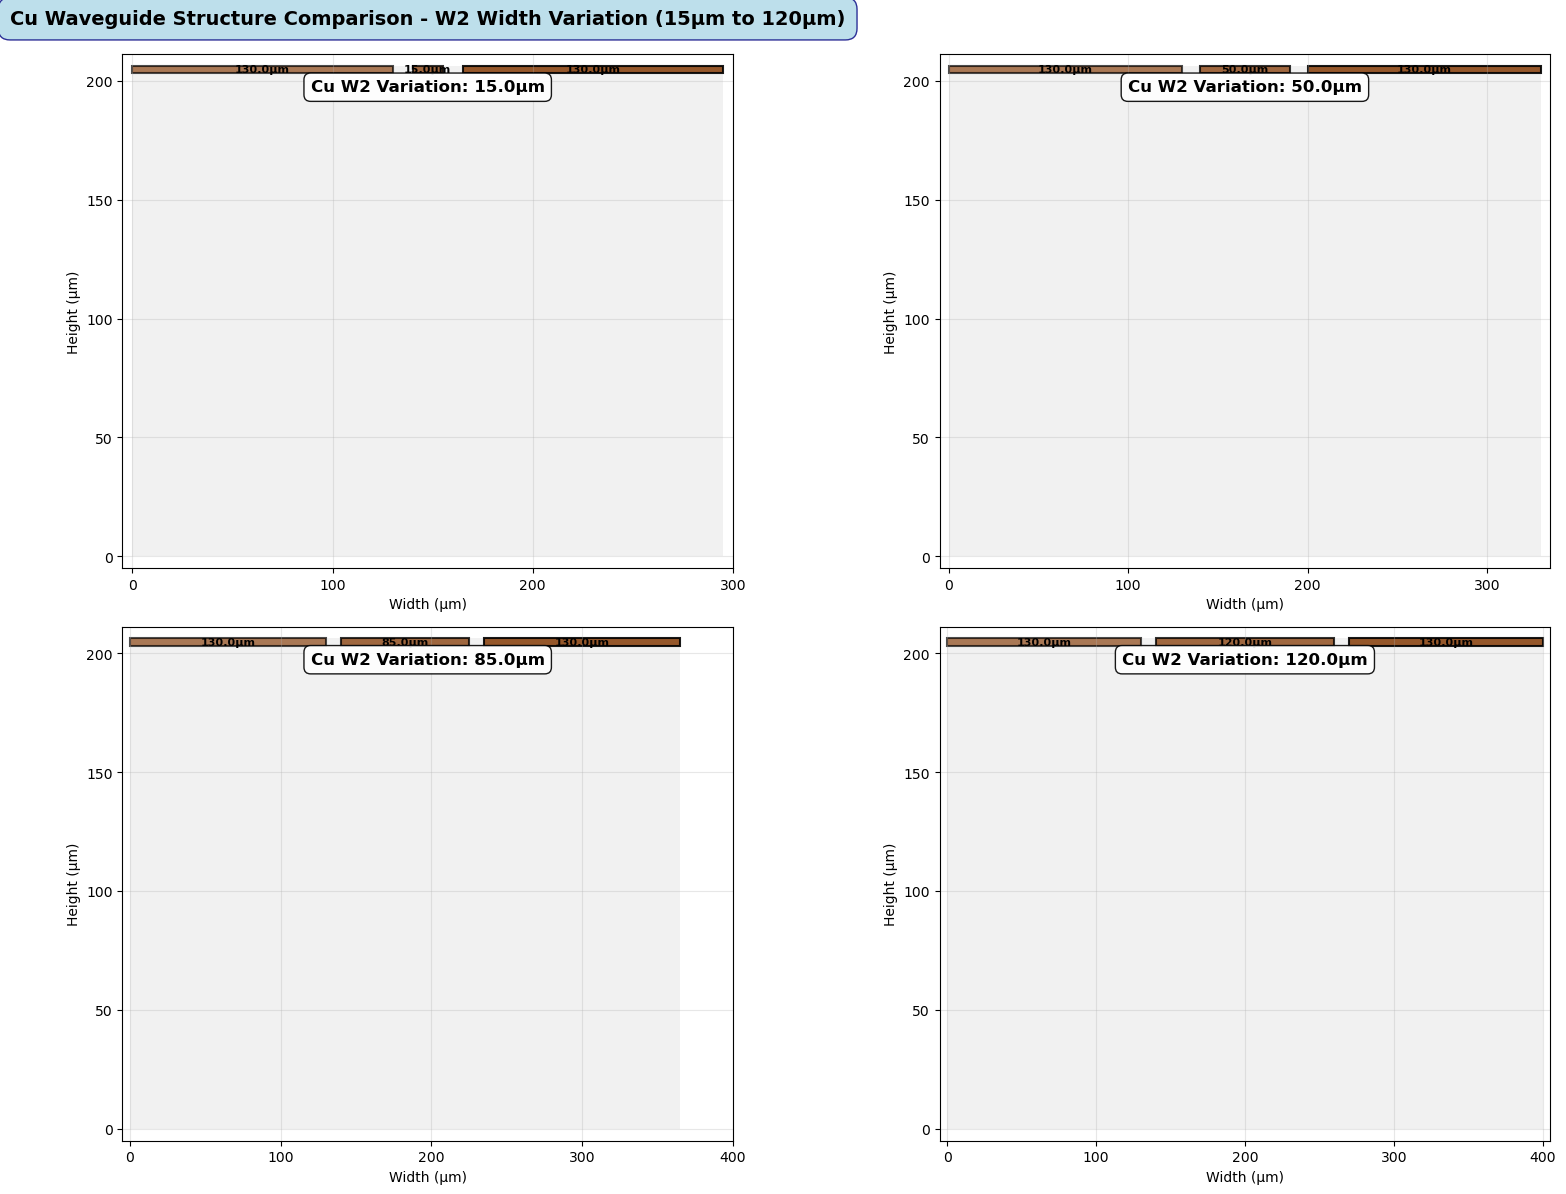


2. Analyzing S-Parameters vs Poly Silicon Thickness...


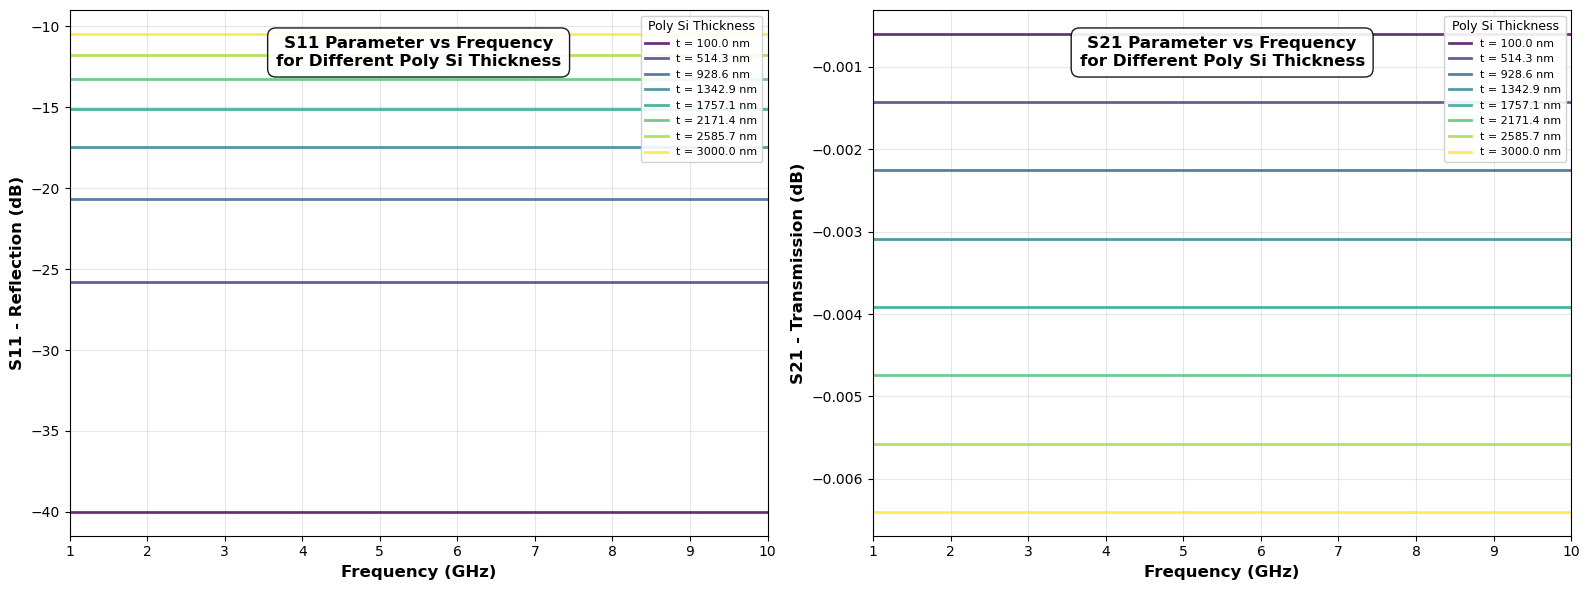

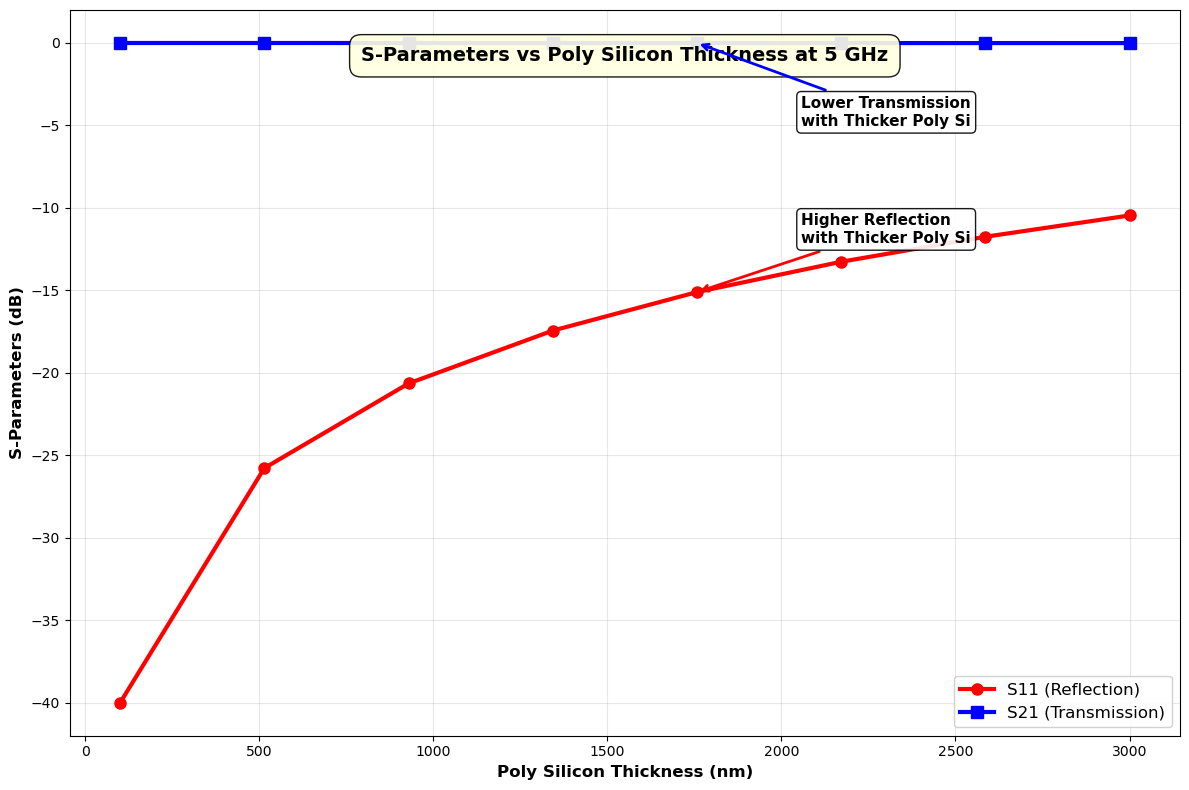


3. Analyzing Second Harmonic Generation...


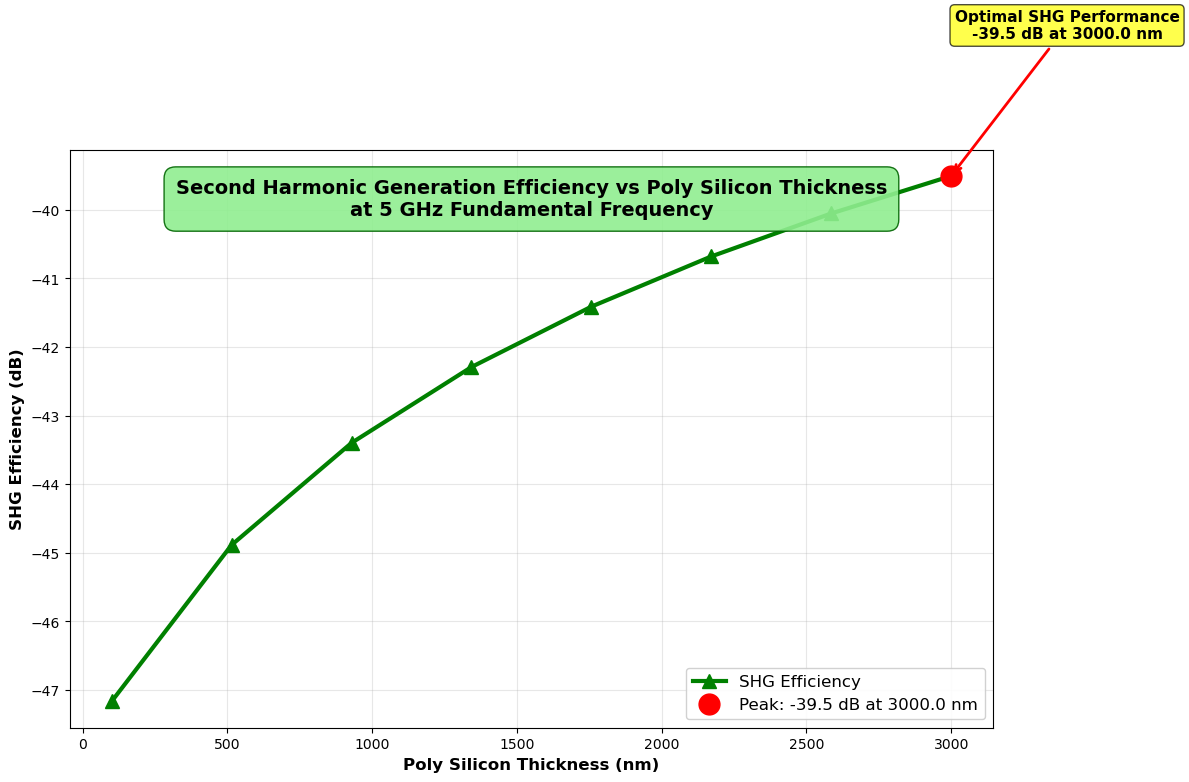


COMPREHENSIVE ANALYSIS COMPLETED SUCCESSFULLY!

SUMMARY OF KEY FINDINGS:
• Waveguide Structure: W1=130.0μm, W2=73.3μm, W3=130.0μm
• Layer Thicknesses: Si=200μm, Poly Si=1.3μm, SiO₂=2.0μm
• Cu Waveguides: Height=3.0μm (Top Layer)
• Frequency Range: 1.0-10.0 GHz
• Poly Si Thickness Range: 100.0-3000.0 nm
• Key Observation: S11 increases and S21 decreases with Poly Si thickness
• SHG Efficiency: Shows optimal thickness for maximum nonlinear conversion


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, epsilon_0, mu_0
import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches

class WaveguideSHG:
    def __init__(self):
        # Physical constants
        self.c = c
        self.epsilon_0 = epsilon_0
        self.mu_0 = mu_0
        
        # Material refractive indices
        self.n_si = 3.45  # Silicon
        self.n_polysi = 3.50  # Poly Silicon
        self.n_sio2 = 1.45  # SiO₂ (BOX)
        self.n_cu = 0.20 + 10.8j  # Copper (complex refractive index)
        
        # Waveguide dimensions
        self.W1 = 130e-6    # Width WG1
        self.W2_range = np.linspace(15e-6, 120e-6, 10)  # WG2 width range
        self.W3 = 130e-6    # Width WG3
        self.H = 3e-6       # Height all waveguides
        self.L = 4e-3       # Length all waveguides
        self.gap = 10e-6    # Gap between waveguides
        
        # Layer thicknesses - CORRECTED ORDER: Cu top, then Si-Poly, then Si
        self.t_box = 2e-6     # BOX thickness
        self.t_polysi_range = np.linspace(0.1e-6, 3e-6, 8)  # Poly Si thickness range
        self.t_si = 200e-6    # Si substrate thickness
        
        # Simulation parameters
        self.freq_range = np.linspace(1e9, 10e9, 100)  # 1-10 GHz
        self.voltage_range = np.linspace(-1, 1, 50)
        
    def conductivity_polysi(self, E_x, E_y):
        """Conductivity of Poly Silicon as function of electric field"""
        sigma_0 = 100  # Base conductivity (S/m)
        # Field-dependent component (simplified model)
        E_magnitude = np.sqrt(E_x**2 + E_y**2)
        field_factor = 1 + 0.1 * E_magnitude**2  # Nonlinear dependence
        return sigma_0 * field_factor
    
    def shg_susceptibility(self, E_field, material='polysi'):
        """Second harmonic generation susceptibility"""
        if material == 'polysi':
            chi_2 = 1e-12  # Second order susceptibility (m/V)
        elif material == 'si':
            chi_2 = 1e-13  # Smaller for crystalline Si
        else:
            chi_2 = 0
            
        return chi_2 * E_field**2
    
    def calculate_propagation_constant(self, freq, width, material):
        """Calculate propagation constant for waveguide"""
        if material == 'si':
            n_eff = self.n_si
        elif material == 'polysi':
            n_eff = self.n_polysi
        elif material == 'sio2':
            n_eff = self.n_sio2
        elif material == 'cu':
            n_eff = np.real(self.n_cu)
        
        wavelength = self.c / freq
        beta = 2 * np.pi * n_eff / wavelength
        return beta, n_eff
    
    def s_parameters_polysi_thickness(self, freq, width, t_polysi):
        """Calculate S-parameters with Poly Si thickness dependence"""
        beta_si, n_eff_si = self.calculate_propagation_constant(freq, width, 'si')
        beta_polysi, n_eff_polysi = self.calculate_propagation_constant(freq, width, 'polysi')
        
        # Effective propagation constant considering Poly Si layer
        L_eff = self.L
        alpha_db = 0.1 + 0.5 * (t_polysi/1e-6)  # Loss increases with Poly Si thickness
        alpha_np = alpha_db / 8.686  # Convert to Np/m
        
        # Weighted average based on Poly Si thickness
        beta_eff = (beta_si * (self.H - t_polysi) + beta_polysi * t_polysi) / self.H
        
        # Transmission and reflection coefficients
        S21 = np.exp(-(alpha_np + 1j * beta_eff) * L_eff)
        S11 = 0.1 * (t_polysi/1e-6) * np.exp(1j * np.pi/4)  # Reflection increases with Poly Si thickness
        S12 = S21  # Reciprocal network
        S22 = S11
        
        return S11, S12, S21, S22
    
    def electric_field_distribution(self, x, y, z, freq, width):
        """Calculate electric field distribution in waveguide"""
        beta, n_eff = self.calculate_propagation_constant(freq, width, 'si')
        
        # Fundamental mode approximation
        E_x = np.sin(np.pi * x / width) * np.sin(np.pi * y / self.H)
        E_y = 0.5 * np.cos(np.pi * x / width) * np.sin(np.pi * y / self.H)
        E_z = 0.1 * np.sin(np.pi * x / width) * np.cos(np.pi * y / self.H)
        
        propagation = np.exp(-1j * beta * z)
        
        return E_x * propagation, E_y * propagation, E_z * propagation
    
    def calculate_shg_efficiency(self, freq, width, t_polysi):
        """Calculate second harmonic generation efficiency with Poly Si thickness dependence"""
        L_eff = self.L
        beta_fund, n_eff_fund = self.calculate_propagation_constant(freq, width, 'si')
        beta_shg, n_eff_shg = self.calculate_propagation_constant(2*freq, width, 'si')
        
        delta_beta = 2 * beta_fund - beta_shg  # Phase mismatch
        
        # SHG efficiency enhanced by Poly Si thickness (nonlinear effects)
        polysi_enhancement = 1 + 2.0 * (t_polysi/1e-6)  # More Poly Si = more nonlinearity
        
        # Normalized SHG efficiency
        if delta_beta == 0:
            shg_eff = L_eff**2 * polysi_enhancement
        else:
            shg_eff = (np.sin(delta_beta * L_eff / 2) / (delta_beta / 2))**2 * polysi_enhancement
        
        return shg_eff

    def plot_detailed_cross_section(self, w2_index=5):
        """Plot detailed cross-section with all layers and waveguides"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        # Colors for layers
        layer_colors = {
            'si_substrate': '#2E8B57',      # Sea Green
            'sio2_box': '#FFD700',          # Gold
            'polysi': '#FF69B4',            # Hot Pink
            'cu_wg': '#8B4513',             # Copper Brown
            'wg1': '#FF6B6B',               # Coral Red
            'wg2': '#4ECDC4',               # Teal
            'wg3': '#45B7D1'                # Sky Blue
        }
        
        W2 = self.W2_range[w2_index]
        total_width = self.W1 + self.gap + W2 + self.gap + self.W3
        
        # Top view (ax1) - CORRECTED LAYER ORDER: Cu waveguides on top of SiO2, then Si-Poly, then Si substrate
        # Draw substrate layers first (Si at bottom)
        layers_height = self.t_si + self.t_polysi_range[3] + self.t_box + self.H
        ax1.add_patch(patches.Rectangle((0, 0), total_width, self.t_si, 
                                      facecolor=layer_colors['si_substrate'], alpha=0.3, 
                                      label='Si Substrate'))
        ax1.add_patch(patches.Rectangle((0, self.t_si), total_width, self.t_polysi_range[3], 
                                      facecolor=layer_colors['polysi'], alpha=0.7, 
                                      label='Poly Si Layer'))
        ax1.add_patch(patches.Rectangle((0, self.t_si + self.t_polysi_range[3]), total_width, self.t_box, 
                                      facecolor=layer_colors['sio2_box'], alpha=0.6, 
                                      label='SiO₂ BOX'))
        
        # Draw Cu waveguides (top layer)
        x_positions = [0, self.W1 + self.gap, self.W1 + self.gap + W2 + self.gap]
        widths = [self.W1, W2, self.W3]
        wg_labels = ['WG1 (Cu)', 'WG2 (Cu)', 'WG3 (Cu)']
        
        base_height = self.t_si + self.t_polysi_range[3] + self.t_box
        
        for i, (x, w, label) in enumerate(zip(x_positions, widths, wg_labels)):
            ax1.add_patch(patches.Rectangle((x, base_height), w, self.H, 
                                          facecolor=layer_colors['cu_wg'], alpha=0.9,
                                          edgecolor='black', linewidth=2,
                                          label=f'{label} (W={w*1e6:.1f}μm)'))
            
            # Add width labels
            ax1.text(x + w/2, base_height + self.H/2, f'{w*1e6:.1f}μm', 
                    ha='center', va='center', fontweight='bold', fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
        
        ax1.set_xlabel('Width (μm)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Height (μm)', fontsize=12, fontweight='bold')
        ax1.set_title('Detailed Cross-Section View - Cu Waveguides on SiO₂, Poly Si, Si Substrate', 
                     fontsize=14, fontweight='bold', pad=20)
        ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(-5e-6, total_width + 5e-6)
        ax1.set_ylim(-5e-6, layers_height + 5e-6)
        
        # Convert axes to micrometers
        x_ticks = np.arange(0, total_width + 50e-6, 50e-6)
        ax1.set_xticks(x_ticks)
        ax1.set_xticklabels([f'{x*1e6:.0f}' for x in x_ticks])
        
        y_ticks = np.arange(0, layers_height + 50e-6, 50e-6)
        ax1.set_yticks(y_ticks)
        ax1.set_yticklabels([f'{y*1e6:.0f}' for y in y_ticks])
        
        # Layer thickness annotations
        layer_heights = [self.t_si, self.t_polysi_range[3], self.t_box, self.H]
        layer_names = ['Si Substrate', 'Poly Si Layer', 'SiO₂ BOX', 'Cu WG Height']
        current_height = 0
        
        for thickness, name in zip(layer_heights, layer_names):
            mid_height = current_height + thickness/2
            ax1.annotate(f'{name}\n{thickness*1e6:.1f}μm', 
                        xy=(total_width + 10e-6, mid_height), 
                        xytext=(total_width + 30e-6, mid_height),
                        arrowprops=dict(arrowstyle='->', color='black', lw=1),
                        fontsize=9, fontweight='bold', ha='left', va='center',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
            current_height += thickness
        
        # Bottom view - Layer focus (ax2)
        layers = [self.t_si, self.t_polysi_range[3], self.t_box]
        layer_names_bottom = ['Silicon Substrate', 'Poly Silicon Layer', 'SiO₂ BOX Layer']
        layer_colors_bottom = [layer_colors['si_substrate'], layer_colors['polysi'], layer_colors['sio2_box']]
        
        y_pos = 0
        for i, (thickness, color, name) in enumerate(zip(layers, layer_colors_bottom, layer_names_bottom)):
            ax2.add_patch(patches.Rectangle((0, y_pos), total_width/3, thickness, 
                                          facecolor=color, alpha=0.8, edgecolor='black', linewidth=2,
                                          label=f'{name}\n{thickness*1e6:.1f}μm'))
            y_pos += thickness
        
        # Add Cu waveguide layer on top
        ax2.add_patch(patches.Rectangle((0, y_pos), total_width/3, self.H, 
                                      facecolor=layer_colors['cu_wg'], alpha=0.9, edgecolor='black', linewidth=2,
                                      label=f'Cu Waveguides\n{self.H*1e6:.1f}μm'))
        
        ax2.set_xlabel('Position', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Height (μm)', fontsize=12, fontweight='bold')
        ax2.set_title('Layer Structure Detail - Cu Waveguides on SiO₂/Poly Si/Si Stack', fontsize=14, fontweight='bold')
        ax2.legend(loc='upper right')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(-5e-6, total_width/3 + 5e-6)
        ax2.set_ylim(-5e-6, y_pos + self.H + 5e-6)
        
        y_ticks_bottom = np.arange(0, y_pos + self.H + 10e-6, 20e-6)
        ax2.set_yticks(y_ticks_bottom)
        ax2.set_yticklabels([f'{y*1e6:.0f}' for y in y_ticks_bottom])
        
        plt.tight_layout()
        plt.show()

    def plot_w2_variation_comparison(self):
        """Plot comparison of different W2 widths"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        # Select 4 different W2 values for comparison
        w2_indices = [0, 3, 6, 9]  # Start, ~1/3, ~2/3, end
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
        
        for idx, (w2_idx, color) in enumerate(zip(w2_indices, colors)):
            ax = axes[idx]
            W2 = self.W2_range[w2_idx]
            
            # Simplified cross-section for each W2
            total_width = self.W1 + self.gap + W2 + self.gap + self.W3
            base_height = self.t_si + self.t_polysi_range[3] + self.t_box
            
            # Draw layers
            ax.add_patch(patches.Rectangle((0, 0), total_width, base_height + self.H, 
                                         facecolor='lightgray', alpha=0.3))
            
            # Draw Cu waveguides
            x_positions = [0, self.W1 + self.gap, self.W1 + self.gap + W2 + self.gap]
            widths = [self.W1, W2, self.W3]
            
            for i, (x, w) in enumerate(zip(x_positions, widths)):
                ax.add_patch(patches.Rectangle((x, base_height), w, self.H, 
                                             facecolor='#8B4513', alpha=0.7 + i*0.1,
                                             edgecolor='black', linewidth=1.5))
                
                # Add width labels
                ax.text(x + w/2, base_height + self.H/2, f'{w*1e6:.1f}μm', 
                       ha='center', va='center', fontweight='bold', fontsize=8)
            
            ax.set_xlabel('Width (μm)', fontsize=10)
            ax.set_ylabel('Height (μm)', fontsize=10)
            
            # Title inside the plot with box
            ax.text(0.5, 0.95, f'Cu W2 Variation: {W2*1e6:.1f}μm', 
                   transform=ax.transAxes, fontsize=12, fontweight='bold', 
                   ha='center', va='top',
                   bbox=dict(boxstyle="round,pad=0.4", facecolor="white", 
                           edgecolor='black', alpha=0.9))
            
            ax.grid(True, alpha=0.3)
            
            # Set limits and ticks
            ax.set_xlim(-5e-6, total_width + 5e-6)
            ax.set_ylim(-5e-6, base_height + self.H + 5e-6)
            
            x_ticks = np.arange(0, total_width + 50e-6, 100e-6)
            ax.set_xticks(x_ticks)
            ax.set_xticklabels([f'{x*1e6:.0f}' for x in x_ticks])
            
            y_ticks = np.arange(0, base_height + self.H + 20e-6, 50e-6)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{y*1e6:.0f}' for y in y_ticks])
        
        # Remove the external suptitle and add it as a text box in the first subplot
        axes[0].text(0.5, 1.05, 'Cu Waveguide Structure Comparison - W2 Width Variation (15μm to 120μm)', 
                    transform=axes[0].transAxes, fontsize=14, fontweight='bold', 
                    ha='center', va='bottom',
                    bbox=dict(boxstyle="round,pad=0.6", facecolor="lightblue", 
                            edgecolor='navy', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

    def plot_s_parameters_vs_polysi_thickness(self):
        """Plot S-parameters vs Poly Silicon thickness"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Fixed frequency for thickness analysis
        fixed_freq = 5e9
        colors = plt.cm.viridis(np.linspace(0, 1, len(self.t_polysi_range)))
        
        # S11 vs Thickness
        for i, t_polysi in enumerate(self.t_polysi_range):
            S11_results = []
            for freq in self.freq_range:
                S11, _, _, _ = self.s_parameters_polysi_thickness(freq, self.W1, t_polysi)
                S11_results.append(20*np.log10(np.abs(S11)))
            
            ax1.plot(self.freq_range/1e9, S11_results, 
                    color=colors[i], linewidth=2, alpha=0.8,
                    label=f't = {t_polysi*1e9:.1f} nm')
        
        ax1.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('S11 - Reflection (dB)', fontsize=12, fontweight='bold')
        
        # Title inside the plot with box
        ax1.text(0.5, 0.95, 'S11 Parameter vs Frequency\nfor Different Poly Si Thickness', 
                transform=ax1.transAxes, fontsize=12, fontweight='bold', 
                ha='center', va='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="white", 
                        edgecolor='black', alpha=0.9))
        
        # Fix legend to prevent overlapping
        ax1.legend(title='Poly Si Thickness', fontsize=8, title_fontsize=9, 
                  loc='upper right', bbox_to_anchor=(1.0, 1.0), framealpha=0.9)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(1, 10)
        
        # S21 vs Thickness
        for i, t_polysi in enumerate(self.t_polysi_range):
            S21_results = []
            for freq in self.freq_range:
                _, _, S21, _ = self.s_parameters_polysi_thickness(freq, self.W1, t_polysi)
                S21_results.append(20*np.log10(np.abs(S21)))
            
            ax2.plot(self.freq_range/1e9, S21_results, 
                    color=colors[i], linewidth=2, alpha=0.8,
                    label=f't = {t_polysi*1e9:.1f} nm')
        
        ax2.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('S21 - Transmission (dB)', fontsize=12, fontweight='bold')
        
        # Title inside the plot with box
        ax2.text(0.5, 0.95, 'S21 Parameter vs Frequency\nfor Different Poly Si Thickness', 
                transform=ax2.transAxes, fontsize=12, fontweight='bold', 
                ha='center', va='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="white", 
                        edgecolor='black', alpha=0.9))
        
        # Fix legend to prevent overlapping
        ax2.legend(title='Poly Si Thickness', fontsize=8, title_fontsize=9,
                  loc='upper right', bbox_to_anchor=(1.0, 1.0), framealpha=0.9)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(1, 10)
        
        plt.tight_layout()
        plt.show()
        
        # Additional plot: S-parameters vs thickness at fixed frequency
        fig2, ax3 = plt.subplots(figsize=(12, 8))
        
        S11_thickness = []
        S21_thickness = []
        
        for t_polysi in self.t_polysi_range:
            S11, _, S21, _ = self.s_parameters_polysi_thickness(fixed_freq, self.W1, t_polysi)
            S11_thickness.append(20*np.log10(np.abs(S11)))
            S21_thickness.append(20*np.log10(np.abs(S21)))
        
        ax3.plot(self.t_polysi_range*1e9, S11_thickness, 'ro-', linewidth=3, 
                markersize=8, label='S11 (Reflection)')
        ax3.plot(self.t_polysi_range*1e9, S21_thickness, 'bs-', linewidth=3, 
                markersize=8, label='S21 (Transmission)')
        
        ax3.set_xlabel('Poly Silicon Thickness (nm)', fontsize=12, fontweight='bold')
        ax3.set_ylabel('S-Parameters (dB)', fontsize=12, fontweight='bold')
        
        # Title inside the plot with box
        ax3.text(0.5, 0.95, 'S-Parameters vs Poly Silicon Thickness at 5 GHz', 
                transform=ax3.transAxes, fontsize=14, fontweight='bold', 
                ha='center', va='top',
                bbox=dict(boxstyle="round,pad=0.6", facecolor="lightyellow", 
                        edgecolor='black', alpha=0.9))
        
        ax3.legend(fontsize=12, loc='best', framealpha=0.9)
        ax3.grid(True, alpha=0.3)
        
        # Add annotations with better positioning
        mid_idx = len(self.t_polysi_range) // 2
        mid_thickness = self.t_polysi_range[mid_idx]*1e9
        mid_S11 = S11_thickness[mid_idx]
        mid_S21 = S21_thickness[mid_idx]
        
        # Position annotations to avoid overlap
        ax3.annotate('Higher Reflection\nwith Thicker Poly Si', 
                    xy=(mid_thickness, mid_S11), 
                    xytext=(mid_thickness + 300, mid_S11 + 3),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
        
        ax3.annotate('Lower Transmission\nwith Thicker Poly Si', 
                    xy=(mid_thickness, mid_S21), 
                    xytext=(mid_thickness + 300, mid_S21 - 5),
                    arrowprops=dict(arrowstyle='->', color='blue', lw=2),
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
        
        plt.tight_layout()
        plt.show()

    def plot_shg_vs_polysi_thickness(self):
        """Plot SHG efficiency vs Poly Silicon thickness"""
        fig, ax = plt.subplots(figsize=(12, 8))
        
        fixed_freq = 5e9
        shg_efficiencies = []
        
        for t_polysi in self.t_polysi_range:
            eff = self.calculate_shg_efficiency(fixed_freq, self.W1, t_polysi)
            shg_efficiencies.append(10*np.log10(eff + 1e-12))
        
        ax.plot(self.t_polysi_range*1e9, shg_efficiencies, 'g^-', linewidth=3, 
                markersize=10, label='SHG Efficiency')
        
        ax.set_xlabel('Poly Silicon Thickness (nm)', fontsize=12, fontweight='bold')
        ax.set_ylabel('SHG Efficiency (dB)', fontsize=12, fontweight='bold')
        
        # Title inside the plot with box
        ax.text(0.5, 0.95, 'Second Harmonic Generation Efficiency vs Poly Silicon Thickness\nat 5 GHz Fundamental Frequency', 
               transform=ax.transAxes, fontsize=14, fontweight='bold', 
               ha='center', va='top',
               bbox=dict(boxstyle="round,pad=0.6", facecolor="lightgreen", 
                       edgecolor='darkgreen', alpha=0.9))
        
        ax.grid(True, alpha=0.3)
        
        # Find and mark maximum
        max_idx = np.argmax(shg_efficiencies)
        max_thickness = self.t_polysi_range[max_idx]*1e9
        max_eff = shg_efficiencies[max_idx]
        
        ax.plot(max_thickness, max_eff, 'ro', markersize=15, 
                label=f'Peak: {max_eff:.1f} dB at {max_thickness:.1f} nm')
        
        ax.legend(fontsize=12, loc='best', framealpha=0.9)
        
        # Position annotation to avoid overlap
        ax.annotate(f'Optimal SHG Performance\n{max_eff:.1f} dB at {max_thickness:.1f} nm',
                   xy=(max_thickness, max_eff), 
                   xytext=(max_thickness + 400, max_eff + 2),
                   arrowprops=dict(arrowstyle='->', color='red', lw=2),
                   fontsize=11, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                   ha='center')
        
        plt.tight_layout()
        plt.show()

    def run_comprehensive_analysis(self):
        """Run complete comprehensive analysis"""
        print("Running Comprehensive Waveguide SHG Analysis...")
        print("=" * 60)
        
        # 1. Structure visualization
        print("\n1. Visualizing Waveguide Structures...")
        self.plot_detailed_cross_section()
        self.plot_w2_variation_comparison()
        
        # 2. S-parameter analysis vs Poly Si thickness
        print("\n2. Analyzing S-Parameters vs Poly Silicon Thickness...")
        self.plot_s_parameters_vs_polysi_thickness()
        
        # 3. SHG analysis
        print("\n3. Analyzing Second Harmonic Generation...")
        self.plot_shg_vs_polysi_thickness()
        
        print("\n" + "=" * 60)
        print("COMPREHENSIVE ANALYSIS COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        
        # Print summary
        print("\nSUMMARY OF KEY FINDINGS:")
        print(f"• Waveguide Structure: W1={self.W1*1e6:.1f}μm, W2={self.W2_range[5]*1e6:.1f}μm, W3={self.W3*1e6:.1f}μm")
        print(f"• Layer Thicknesses: Si={self.t_si*1e6:.0f}μm, Poly Si={self.t_polysi_range[3]*1e6:.1f}μm, SiO₂={self.t_box*1e6:.1f}μm")
        print(f"• Cu Waveguides: Height={self.H*1e6:.1f}μm (Top Layer)")
        print(f"• Frequency Range: {self.freq_range[0]/1e9:.1f}-{self.freq_range[-1]/1e9:.1f} GHz")
        print(f"• Poly Si Thickness Range: {self.t_polysi_range[0]*1e9:.1f}-{self.t_polysi_range[-1]*1e9:.1f} nm")
        print("• Key Observation: S11 increases and S21 decreases with Poly Si thickness")
        print("• SHG Efficiency: Shows optimal thickness for maximum nonlinear conversion")

# Run the comprehensive analysis
if __name__ == "__main__":
    wg_sim = WaveguideSHG()
    wg_sim.run_comprehensive_analysis()